In [1]:
## Importing libraries and dependencies
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
## Importing CEJST shapefile. If you were to go on CEJST site the files are labeled as 'usa.shp', etc.
data = gpd.read_file('cejst.shp')

## Filtering data for Georgia and assigning geometries to activate shapefiles
ga = data[data['SF'] == 'Georgia']

Map that shows census tracts in GA that are environmentally disadvantaged (SN_C) according to definition N:
Water, Workforce, Climate, Energy, Transportation, Housing, Pollution, Health

Text(0.5, 1.0, 'Environmentally Disadvantaged')

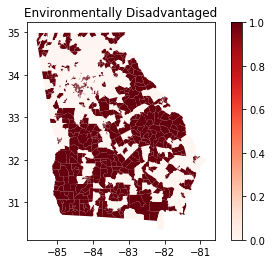

In [3]:
ga.plot(column = 'SN_C', legend = True, cmap = 'Reds')
plt.title('Environmentally Disadvantaged')

TC is total CEJST criteria exceed (there is similarly named column, so I need to double-check this is what I think it is)

Text(0.5, 1.0, 'Total Criteria Exceeded')

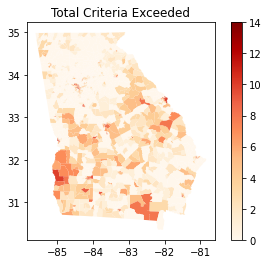

In [4]:
ga.plot(column = 'TC', legend = True, cmap = 'OrRd')
plt.title('Total Criteria Exceeded')

D:\Anaconda\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'Nonwhite Popluations')

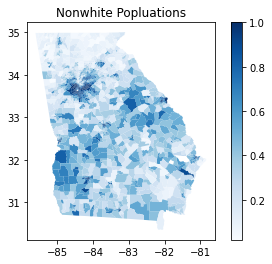

In [5]:
ga['Nonwhite Percent'] = 1- ga.loc[:,'DM_W'] # DM_W is % white
ga.plot(column = 'Nonwhite Percent', legend = True, cmap = 'Blues')
plt.title('Nonwhite Popluations')

/Users/jacoblapp/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'Nonwhite% * Criteria Exceeded')

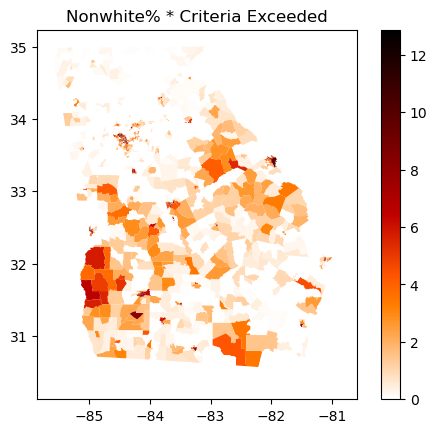

In [49]:
ga['nw_dis'] = ga['Nonwhite Percent'] * ga['TC']
ga.plot(column = 'nw_dis', legend = True, cmap = 'gist_heat_r')
plt.title('Nonwhite% * Criteria Exceeded')

In [6]:
## Loading EJScreen census tract (NOT block group) geopandas database
ej = gpd.read_file('EJSCREEN_2023_Tracts_StatePct_with_AS_CNMI_GU_VI.gdb')

## filtering data for Georgia and assigning geometries to activate shapefiles
ga_ej = ej[ej['STATE_NAME'] == 'Georgia']

In [51]:
#ga_ej.plot(column = 'DEMOGIDX_2', legend = True, cmap='BuPu') # DEMOGIDX_2 is ejscreen demographic index
#plt.xlabel("X Coordinates")
#plt.ylabel("Y Coordinates")
#plt.title("EJ Screen Demographic Index")
#plt.show()

Here, I am trying to merge the EJScreen info with the CEJST shp files
For the first step in making the index, I want to essentially multiply the CEJST burdens 
by the EJScreen demographic information (particularly the demographic index). The final index will obviously be more nuanced.
I believe the main roadblock here is that EJScreen uses 2020 Census tracts (and IDs) while CEJST still uses 2010
If we are able to convert/transform one of the datasets to match with the other, we should be good to merge the CEJST and EJScreen and start calculating the index.

In [52]:
ga.head()

,GEOID10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,...,AGE_OLD,TA_COU_116,TA_COUNT_C,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,geometry,Nonwhite Percent,nw_dis
18332,13135050709,Georgia,Gwinnett County,0.68,0.54,0.27,0.59,0.61,0.61,0.51,...,0.10,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.02605 33.78081, -84.02494 33.781...",0.80,0.0
18333,13135050314,Georgia,Gwinnett County,0.43,0.16,0.10,0.89,0.59,0.36,0.56,...,0.06,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.17614 33.96054, -84.17591 33.961...",0.80,0.8
18334,13135050315,Georgia,Gwinnett County,0.33,0.27,0.12,0.89,0.44,0.44,0.55,...,0.05,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.26148 33.96100, -84.26135 33.960...",0.72,0.0
18335,13135050415,Georgia,Gwinnett County,0.75,0.14,0.60,0.72,0.72,0.26,0.51,...,0.22,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.10476 33.82465, -84.10303 33.825...",0.58,0.0
18336,13135050425,Georgia,Gwinnett County,0.43,0.06,0.35,0.74,0.32,0.51,0.53,...,0.13,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.14660 33.86681, -84.14655 33.867...",0.46,0.0


In [53]:
ga = ga.rename(columns={'GEOID10': 'GEOID_TRACT_10'}) # rename original ga 2010 column to match fips conversion df
ga.GEOID_TRACT_10 = np.int64(ga.GEOID_TRACT_10) # making sure ga 2010 is int64

conv = pd.read_csv('ga_fips_conv.csv') # this is relationship table for 2010 and 2020 IDs
conv

,GEOID_TRACT_20,GEOID_TRACT_10
0,13001950100,13001950100
1,13001950201,13001950200
2,13001950202,13001950200
3,13001950301,13001950300
4,13001950302,13001950300
...,...,...
3703,13319960300,13319960300
3704,13319960400,13319960400
3705,13321950100,13321950100
3706,13321950201,13321950200


Below, i merge the fips conversion table (the dataframe 'conv') with the georgia cejst data so we have 2020 fips codes (which we need to combine with the EJ data)

In [54]:
ga2 = pd.merge(ga, conv, on = 'GEOID_TRACT_10') 
ga2.head(3)

,GEOID_TRACT_10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,...,TA_COU_116,TA_COUNT_C,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,geometry,Nonwhite Percent,nw_dis,GEOID_TRACT_20
0,13135050709,Georgia,Gwinnett County,0.68,0.54,0.27,0.59,0.61,0.61,0.51,...,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.02605 33.78081, -84.02494 33.781...",0.8,0.0,13135050416
1,13135050709,Georgia,Gwinnett County,0.68,0.54,0.27,0.59,0.61,0.61,0.51,...,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.02605 33.78081, -84.02494 33.781...",0.8,0.0,13135050732
2,13135050709,Georgia,Gwinnett County,0.68,0.54,0.27,0.59,0.61,0.61,0.51,...,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.02605 33.78081, -84.02494 33.781...",0.8,0.0,13135050733


In [65]:
ga_ej = ga_ej.rename(columns={'ID': 'GEOID_TRACT_20'}) #renaming the ID column in the ga_ej df so merge will be cleaner
ga_ej.GEOID_TRACT_20 = np.int64(ga_ej.GEOID_TRACT_20) # making sure EJ geotract20 is int64
ga_ej.head(3)

,GEOID_TRACT_20,STATE_NAME,ST_ABBREV,CNTY_NAME,REGION,ACSTOTPOP,ACSIPOVBAS,ACSEDUCBAS,ACSTOTHH,ACSTOTHU,...,P_D5_PWDIS,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,EXCEED_COUNT_80,EXCEED_COUNT_80_SUP,Shape_Length,Shape_Area,geometry
21289,13001950100,Georgia,GA,Appling,4,3421.0,3399.0,2242.0,1180.0,1553.0,...,80,325861171.0,6481921.0,0,0,0,1.0,1.267735,0.031677,"MULTIPOLYGON (((-82.43165 31.85615, -82.43158 ..."
21290,13001950201,Georgia,GA,Appling,4,2491.0,2491.0,1716.0,934.0,1132.0,...,75,104878149.0,814184.0,0,0,0,0.0,0.507211,0.010067,"MULTIPOLYGON (((-82.35209 31.84147, -82.35145 ..."
21291,13001950202,Georgia,GA,Appling,4,2466.0,2238.0,1530.0,821.0,984.0,...,70,51987913.0,157129.0,0,0,3,3.0,0.427706,0.004967,"MULTIPOLYGON (((-82.45868 31.83810, -82.43136 ..."


Below, we finally are now able to merge the Georgia CEJST and EJScreen data. We merge on the GEOID_TRACT_20 column because now both data sets have those identifiers.

In [67]:
merged_shp = pd.merge(ga2, ga_ej, on = 'GEOID_TRACT_20') # Will return error

In [76]:
print('There are', len(merged_shp.GEOID_TRACT_20.unique()), 'unique 2020 census tract level fips codes.\
 There may be 2796 in actuality, so I cannot forget to check this.')

There are 2793 unique 2020 census tract level fips codes. There may be 2796 in actuality, so I cannot forget to check this.


Here is our new, hopefully final dataset:

In [80]:
pd.set_option('display.max_columns', None)
merged_shp

,GEOID_TRACT_10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,EPLR_PFS,HBF_PFS,LLEF_PFS,LIF_PFS,LMI_PFS,PM25F_PFS,HSEF,P100_PFS,P200_I_PFS,AJDLI_ET,LPF_PFS,KP_PFS,NPL_PFS,RMP_PFS,TSDF_PFS,TPF,TF_PFS,UF_PFS,WF_PFS,UST_PFS,N_WTR,N_WKFC,N_CLT,N_ENY,N_TRN,N_HSG,N_PLN,N_HLTH,SN_C,SN_T,DLI,ALI,PLHSE,LMILHSE,ULHSE,EPL_ET,EAL_ET,EBL_ET,EB_ET,PM25_ET,DS_ET,TP_ET,LPP_ET,HRS_ET,KP_ET,HB_ET,RMP_ET,NPL_ET,TSDF_ET,WD_ET,UST_ET,DB_ET,A_ET,HD_ET,LLE_ET,UN_ET,LISO_ET,POV_ET,LMI_ET,IA_LMI_ET,IA_UN_ET,IA_POV_ET,TC,CC,IAULHSE,IAPLHSE,IALMILHSE,IALMIL_76,IAPLHS_77,IAULHS_78,LHE,IALHE,IAHSEF,N_CLT_EOMI,N_ENY_EOMI,N_TRN_EOMI,N_HSG_EOMI,N_PLN_EOMI,N_WTR_EOMI,N_HLTH_88,N_WKFC_89,FPL200S,N_WKFC_91,TD_ET,TD_PFS,FLD_PFS,WFR_PFS,FLD_ET,WFR_ET,ADJ_ET,IS_PFS,IS_ET,AML_ET,FUDS_RAW,FUDS_ET,IMP_FLG,DM_B,DM_AI,DM_A,DM_HI,DM_T,DM_W,DM_H,DM_O,AGE_10,AGE_MIDDLE,AGE_OLD,TA_COU_116,TA_COUNT_C,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,geometry_x,Nonwhite Percent,nw_dis,GEOID_TRACT_20,STATE_NAME,ST_ABBREV,CNTY_NAME,REGION,ACSTOTPOP,ACSIPOVBAS,ACSEDUCBAS,ACSTOTHH,ACSTOTHU,ACSUNEMPBAS,DEMOGIDX_2,DEMOGIDX_5,PEOPCOLOR,PEOPCOLORPCT,LOWINCOME,LOWINCPCT,UNEMPLOYED,UNEMPPCT,LINGISO,LINGISOPCT,LESSHS,LESSHSPCT,UNDER5,UNDER5PCT,OVER64,OVER64PCT,LIFEEXPPCT,PM25,OZONE,DSLPM,CANCER,RESP,RSEI_AIR,PTRAF,PRE1960,PRE1960PCT,PNPL,PRMP,PTSDF,UST,PWDIS,D2_PM25,D5_PM25,D2_OZONE,D5_OZONE,D2_DSLPM,D5_DSLPM,D2_CANCER,D5_CANCER,D2_RESP,D5_RESP,D2_RSEI_AIR,D5_RSEI_AIR,D2_PTRAF,D5_PTRAF,D2_LDPNT,D5_LDPNT,D2_PNPL,D5_PNPL,D2_PRMP,D5_PRMP,D2_PTSDF,D5_PTSDF,D2_UST,D5_UST,D2_PWDIS,D5_PWDIS,P_DEMOGIDX_2,P_DEMOGIDX_5,P_PEOPCOLORPCT,P_LOWINCPCT,P_UNEMPPCT,P_LINGISOPCT,P_LESSHSPCT,P_UNDER5PCT,P_OVER64PCT,P_LIFEEXPPCT,P_PM25,P_OZONE,P_DSLPM,P_CANCER,P_RESP,P_RSEI_AIR,P_PTRAF,P_LDPNT,P_PNPL,P_PRMP,P_PTSDF,P_UST,P_PWDIS,P_D2_PM25,P_D5_PM25,P_D2_OZONE,P_D5_OZONE,P_D2_DSLPM,P_D5_DSLPM,P_D2_CANCER,P_D5_CANCER,P_D2_RESP,P_D5_RESP,P_D2_RSEI_AIR,P_D5_RSEI_AIR,P_D2_PTRAF,P_D5_PTRAF,P_D2_LDPNT,P_D5_LDPNT,P_D2_PNPL,P_D5_PNPL,P_D2_PRMP,P_D5_PRMP,P_D2_PTSDF,P_D5_PTSDF,P_D2_UST,P_D5_UST,P_D2_PWDIS,P_D5_PWDIS,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,EXCEED_COUNT_80,EXCEED_COUNT_80_SUP,Shape_Length,Shape_Area,geometry_y
0,13135050709,Georgia,Gwinnett County,0.68,0.54,0.27,0.59,0.61,0.61,0.51,0.21,0.58,0.54,0.61,0.49,0.73,0.10,0.62,0.49,0,0.15,0.21,0.03,0.18,0.15,13838.0,0.41,0.64,0.45,0.45,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,NaN,NaN,NaN,1,0,NaN,0,0,1,0,0,0,0,0,0,1,1,0.96,0.59,0.33,0,0,0,0.15,0,0,None,0,0,0.56,0.02,0.01,0.0,0.01,0.20,0.16,0.09,0.09,0.79,0.10,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.02605 33.78081, -84.02494 33.781...",0.80,0.0,13135050416,Georgia,GA,Gwinnett,4,3833.0,3832.0,2225.0,1167.0,1243.0,1915.0,0.573618,0.157570,3048.0,0.795200,1349.0,0.352035,58.0,0.030287,80.0,0.068552,250.0,0.112360,506.0,0.132011,256.0,0.066788,0.224615,10.244665,66.82329,0.316960,40.0,0.5,2419.977517,64.357976,0.0,0.000000,0.033366,0.137664,0.629553,1.502242,9.402055e-07,45.315785,12.448022,39.579610,10.872323,36.137905,9.926903,28.680877,7.878495,33.269817,9.139054,51.051961,14.023721,34.417052,9.454194,0.000000,0.000000,34.417052,9.454194,25.239172,6.933075,45.315785,12.448022,30.401729,8.351204,5.736175,1.575699,76.0,57.0,81.0,55.0,32.0,88.0,52.0,96.0,12.0,66.0,79.0,69.0,63.0,50.0,58.0,89.0,60.0,0.0,60.0,44.0,79.0,53.0,10.0,89.0,87,81.0,79,78.0,76,82.0,80,83.0,82,90,85,74.0,70,0,0,77,71,63,57,86,81,69,62,21.0,14,5663763.0,127732.0,0,0,6,5.0,0.142206,0.000564,"MULTIPOLYGON (((-84.09720 33.79862, -84.09714 ..."
1,13135050416,Georgia,Gwinnett County,0.58,0.29,0.16,0.65,0.83,0.30,0.51,0.21,0.43,0.76,0.82,0.44,0.74,0.05,0.61,0.51,1,0.01,0.64,0.04,0.23,0.18,3895.0,0.47,0.56,0.47,0.46,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0.77,0.28,0.33,0,0,0,0.14,0,0,None,0,0,0.61,0.00,0.01,0.0,0.01,0.19,0.16,0.14,0.10,0.82,0.07,NaN,None,NaN,NaN,Nation,21,"POLYGON ((-84.096

AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.

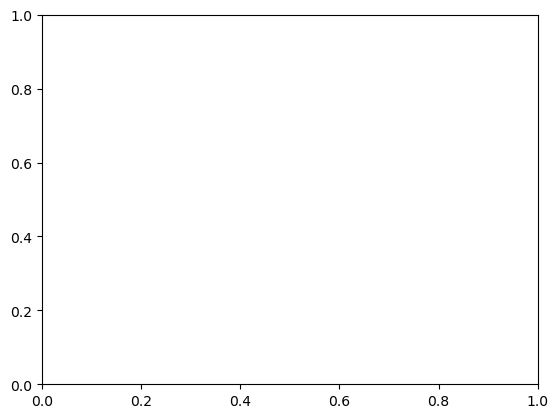

In [81]:
merged_shp['new_index'] = merged_shp['DEMOGIDX_2'] * merged_shp['TC']
merged_shp.plot(column = 'new_index', legend = True, cmap = 'gist_heat_r')
plt.title('New index')
plt.show()

In [57]:
# print(len(ga.GEOID_TRACT_20.unique()) , len(ga_ej.ID.unique()))